In [85]:
import csv

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [86]:
dataset_testGood = 'camera_data_test/hand_landmarks_goodTest.csv'
dataset_testDark = 'camera_data_test/hand_landmarks_darkTest.csv'
dataset_hand_after_sign= 'camera_data_test/hand_landmarks_hand_behind_hand.csv'
model_save_path = 'camera_classifier.keras'
tflite_save_path = 'camera_classifier.tflite'

# Set number of classes

In [106]:
NUM_CLASSES = 24

# Dataset reading

In [128]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1))))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data, axis=0)
X_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_test_hand_behind = np.loadtxt(dataset_hand_after_sign, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [129]:
# Directory containing CSV files
directory = 'camera_data'

# Initialize an empty list to store data from all files
data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
y_dataset = np.concatenate(data, axis=0)
y_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='int32', usecols=(0))
y_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='int32', usecols=(0))
y_test_hand_behind = np.loadtxt(dataset_hand_after_sign, delimiter=',', dtype='float32', usecols=(0))

def adjust_labels(labels):
    return np.where(labels >= 10, labels - 1, labels)

y_dataset = adjust_labels(y_dataset)
y_testGood = adjust_labels(y_testGood)
y_testDark = adjust_labels(y_testDark)
y_test_hand_behind = adjust_labels(y_test_hand_behind)

In [130]:
print("X_dataset shape: " + X_dataset.shape.__str__())
print("y_dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X_test_dataset_good shape: " + X_testGood.shape.__str__())
print("y_test_dataset_good shape: " + y_testGood.shape.__str__())
print("----------------------------------")
print("X_test_dataset_dark shape: " + X_testDark.shape.__str__())
print("y_test_dataset_dark shape: " + y_testDark.shape.__str__())


X_dataset shape: (26400, 42)
y_dataset shape: (26400,)
----------------------------------
X_test_dataset_good shape: (2400, 42)
y_test_dataset_good shape: (2400,)
----------------------------------
X_test_dataset_dark shape: (2400, 42)
y_test_dataset_dark shape: (2400,)


In [131]:
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [132]:
print(X_train)

[[ 0.          0.         -0.14244185 ... -0.71802324  0.10465116
  -0.81395346]
 [ 0.          0.         -0.35887095 ... -0.6895161  -0.9153226
  -0.6330645 ]
 [ 0.          0.          0.13946587 ... -0.6706231  -0.3620178
  -0.79821956]
 ...
 [ 0.          0.          0.21645021 ... -0.47619048 -0.08658009
  -0.4025974 ]
 [ 0.          0.         -0.1891892  ... -0.5243243  -0.42162162
  -0.45945945]
 [ 0.          0.          0.12944162 ... -0.37055838 -0.09390863
  -0.2994924 ]]


# Model building

In [133]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [134]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 21, 2, 1)          0         
                                                                 
 conv2d_18 (Conv2D)          (None, 21, 2, 32)         128       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 10, 2, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 2, 64)         6208      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 5, 2, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 5, 2, 128)        

In [135]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [136]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [137]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
141/145 [============================>.] - ETA: 0s - loss: 1.8530 - accuracy: 0.4237
Epoch 1: saving model to camera_classifier.keras
145/145 [==============================] - 20s 126ms/step - loss: 1.8260 - accuracy: 0.4323 - val_loss: 0.5748 - val_accuracy: 0.8208
Epoch 2/1000
141/145 [============================>.] - ETA: 0s - loss: 0.5365 - accuracy: 0.8190
Epoch 2: saving model to camera_classifier.keras
145/145 [==============================] - 2s 16ms/step - loss: 0.5316 - accuracy: 0.8202 - val_loss: 0.2589 - val_accuracy: 0.9241
Epoch 3/1000
140/145 [===========================>..] - ETA: 0s - loss: 0.3084 - accuracy: 0.8975
Epoch 3: saving model to camera_classifier.keras
145/145 [==============================] - 2s 14ms/step - loss: 0.3066 - accuracy: 0.8983 - val_loss: 0.1526 - val_accuracy: 0.9484
Epoch 4/1000
145/145 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9312
Epoch 4: saving model to camera_classifier.keras
145/145 [=====

In [138]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size=128)

19/19 [==============================] - 0s 4ms/step - loss: 0.0556 - accuracy: 0.9712


In [139]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testDark, y_testDark, batch_size=128)

19/19 [==============================] - 0s 4ms/step - loss: 0.5284 - accuracy: 0.9021


In [140]:
val_loss, val_acc = model.evaluate(X_test_hand_behind, y_test_hand_behind, batch_size=128)

19/19 [==============================] - 0s 4ms/step - loss: 5.1221 - accuracy: 0.6783


In [141]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [142]:
# Inference test
predict_result = model.predict(np.array([X_testGood[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 97ms/step
[1.0000000e+00 0.0000000e+00 3.8243204e-31 1.6042207e-36 3.7975596e-37
 0.0000000e+00 8.0187884e-30 1.1754457e-31 5.6828263e-32 4.7614984e-30
 4.0404820e-27 6.5696341e-22 2.0461127e-24 1.5415237e-35 1.6437315e-27
 4.7166753e-18 0.0000000e+00 7.7861337e-32 1.0295295e-16 2.4496267e-37
 0.0000000e+00 1.4561565e-24 2.1131039e-22 8.7525776e-18]
0


# Confusion matrix

75/75 [==============================] - 0s 3ms/step


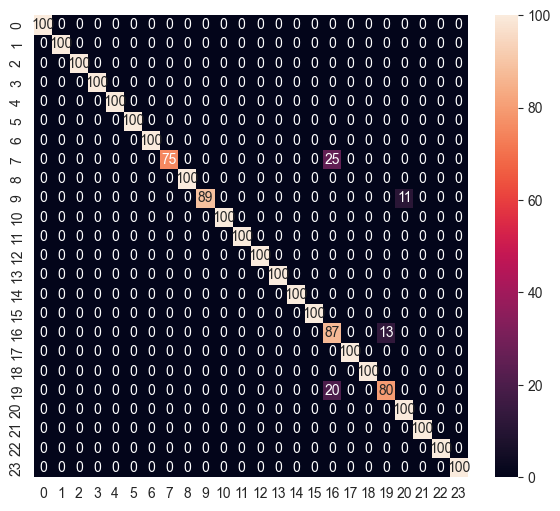

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      0.75      0.86       100
           8       1.00      1.00      1.00       100
           9       1.00      0.89      0.94       100
          10       1.00      1.00      1.00       100
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00       100
          16       0.66      0.87      0.75       100
     

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_testGood, y_pred))

Y_pred = model.predict(X_testGood)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_testGood, y_pred)

# Convert to model for Tensorflow-Lite

In [144]:
tf.saved_model.save(model, "testkeras")

INFO:tensorflow:Assets written to: testkeras\assets


INFO:tensorflow:Assets written to: testkeras\assets


In [145]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp4yaxids3\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp4yaxids3\assets


# Inference test

In [146]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [147]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [148]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_testGood[0]]))

In [149]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.01 ms


In [150]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.00000000e+00 1.54058753e-41 3.82437801e-31 1.60423267e-36
 3.79758789e-37 4.56543040e-42 8.01884706e-30 1.17546344e-31
 5.68282576e-32 4.76153340e-30 4.04054325e-27 6.56968310e-22
 2.04612809e-24 1.54153500e-35 1.64375020e-27 4.71671041e-18
 8.40779079e-45 7.78619187e-32 1.02953334e-16 2.44966321e-37
 3.43318124e-43 1.45616752e-24 2.11311161e-22 8.75264373e-18]
0


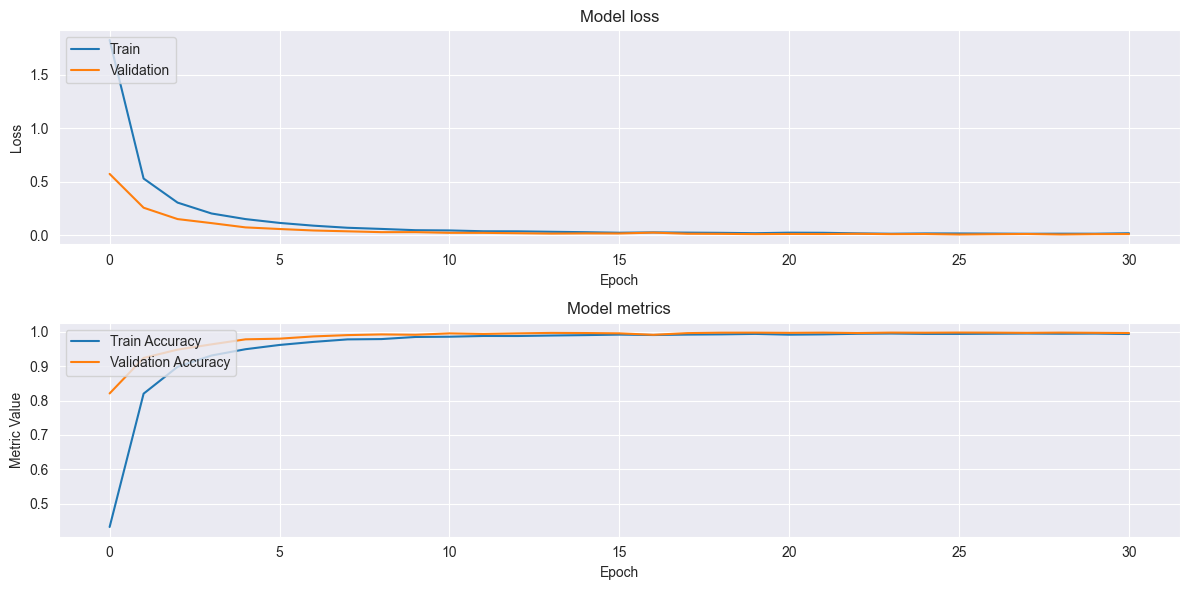

In [151]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()